In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as dset

In [73]:
# Load data

trans = transforms.ToTensor() 
train_set = dset.MNIST(root='MNIST',transform=trans, train=True,  download=True)
test_set = dset.MNIST(root='MNIST', transform=trans,train=False,  download=True)


batch_size = 1000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


train_size, image_h, image_w = train_set.train_data.size()

In [35]:
#Simple VAE model

class VAE(nn.Module):
    def __init__(self,dimZ,dimX):
        super(VAE, self).__init__()
        
        self.dimX = dimX
        self.dimZ = dimZ
        
        self.fc1 = nn.Sequential(
            nn.Linear(dimX, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU())
        self.fc21 = nn.Linear(1000, dimZ)
        self.fc22 = nn.Linear(1000, dimZ)
        self.fc3 = nn.Sequential(
            nn.Linear(dimZ, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU())
        self.fc41 = nn.Linear(1000, dimX)
        self.fc42 = nn.Linear(1000, dimX)
        self.sigmoid = nn.Sigmoid()

        
    def encode(self, x):
        h1 = self.fc1(x)
        mu, logsigma = self.fc21(h1), self.fc22(h1)
        return mu, logsigma

    def decode(self, z):
        h3 = self.fc3(z)
        h4 = self.fc41(h3)
        mu, logsigma = self.sigmoid(h4),self.fc42(h3)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        mu_z, logsigma_z = self.encode(x.view(-1, self.dimX))
        z = self.gaussian_sampler(mu_z.clone(), logsigma_z.clone())
        mu_x, logsigma_x = self.decode(z)
        return mu_x, logsigma_x, mu_z, logsigma_z

In [160]:
# VAE Loss

def KL_divergence(mu, logsigma):
    return -0.5*(1+2*logsigma-mu.pow(2)-(2*logsigma).exp()).sum()

def log_likelihood(x, mu, logsigma):
    
    c = math.log(1/(2*math.pi)**0.5)
    return (c-logsigma-((x-mu)**2)/(2*(2*logsigma).exp())).sum()

def loss_elbo(x, mu_x, logsigma_x, mu_z, logsigma_z,data_size):
    bs,*_ = x.size()
    return (-log_likelihood(x, mu_x, logsigma_x)+KL_divergence(mu_z, logsigma_z))*(data_size/bs)

Epoch 5


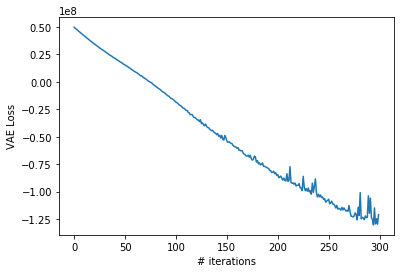

100%|██████████| 60/60 [00:31<00:00,  1.88it/s]


In [161]:
# VAE training

autoencoder = VAE(dimZ = 10,dimX = image_h*image_w)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(),lr = 0.0001)

from tqdm import tqdm
from IPython import display
epochs = 5
losses = []

for epoch in range(epochs):
    for x_batch,_ in tqdm(train_loader):
        autoencoder.train()
        x_batch = x_batch.view(batch_size,-1)
        reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = autoencoder(x_batch)
        loss = loss_elbo(x_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma,train_size)
        losses.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        display.clear_output(wait=True)
        print("Epoch {}".format(epoch+1))
        plt.plot(losses)
        plt.xlabel("# iterations")
        plt.ylabel("VAE Loss")
        plt.show()
        

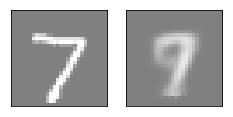

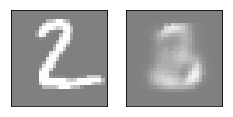

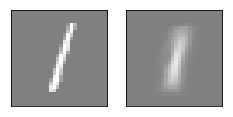

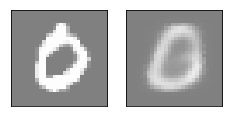

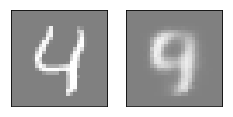

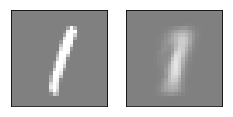

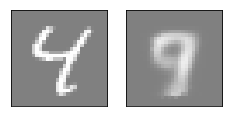

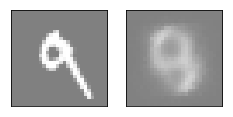

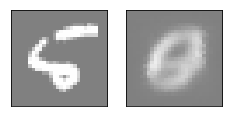

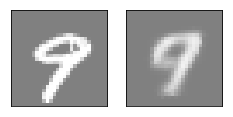

In [165]:
# Check generation quality


def plot_gallery(images, h, w, n_row=3, n_col=6,dim = 1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

vae = autoencoder
vae.eval()
for j, (X_batch,_) in enumerate(test_set):
    input = X_batch#.cuda())
    reconstruction_mu, _, _, _ = vae(input.view(1,-1))
    plot_gallery([X_batch.numpy(), np.clip(reconstruction_mu.data.numpy(),0,1)], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

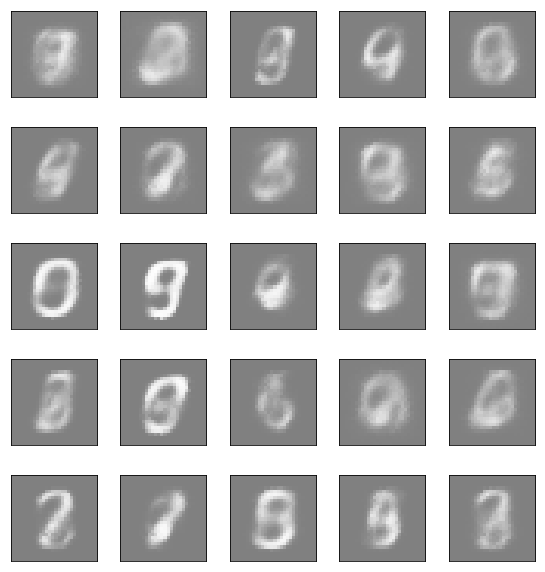

In [166]:
z = (np.random.randn(25, 10)).astype(np.float32)
output,_ = autoencoder.decode(torch.from_numpy(z))#.cuda()))
plot_gallery(np.clip(output.data.cpu().numpy(),0,1), image_h, image_w, n_row=5, n_col=5)

1. SIMPLE 1-D DISTRIBUTIONS

In [642]:
#Data generator

import torch.distributions as dist

class ShiftedExponential(dist.Exponential):
    def __init__(self, rate,shift, validate_args=None):
        self.shift = shift
        super(ShiftedExponential, self).__init__(rate, validate_args=None)
    def rsample(self, sample_shape=torch.Size()):
        s = super(ShiftedExponential, self).rsample(sample_shape)
        return s+self.shift

def get_dist(mean,var):
    l = dist.Laplace(mean,(var/2)**(1/2))
    u = dist.Uniform(mean-(3*var)**(1/2) ,mean+(3*var)**0.5)
    n = dist.Normal(mean,var**(1/2))
    e = ShiftedExponential((1/var)**(1/2),mean-var**(1/2))
    dists = [l,u,n,e]
    i = torch.randint(4,torch.Size([1]))
    return dists[int(i)]

def create_samples(num_samples,mean,var,cls = 0):
    l = dist.Laplace(mean,(var/2)**(1/2))
    u = dist.Uniform(mean-(3*var)**(1/2) ,mean+(3*var)**0.5)
    n = dist.Normal(mean,var**(1/2))
    e = ShiftedExponential((1/var)**(1/2),mean-var**(1/2))
    dists = [l,u,n,e]
    return dists[cls].sample(torch.Size([num_samples]))

def create_random_samples(num_dsets,num_samples):
    mean_dist = dist.Uniform(-1 ,1)
    var_dist = dist.Uniform(0.5 ,2)
    means = mean_dist.sample(torch.Size([num_dsets]))
    vars = var_dist.sample(torch.Size([num_dsets]))
    dsets = []
    for mean,var in zip(means,vars):
        current_dist = get_dist(mean,var)
        dset = current_dist.sample(torch.Size([num_samples]))
        dsets += dset,
    return torch.stack(dsets)

num_dsets = 20000
num_samples = 200
train_size = num_dsets*num_samples
X = create_random_samples(num_dsets,num_samples).unsqueeze(-1)
bs = 1000

train_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.Tensor(X),torch.zeros(len(X)))),\
            batch_size=bs,shuffle=False)
    

In [548]:
# Models

class ObservationDecoder(nn.Module):
    def __init__(self,dimX,dimZ):
        super(ObservationDecoder, self).__init__()
        self.fc_init = nn.Sequential(nn.Linear(dimZ,128),nn.ReLU())
        self.fc_mu = nn.Linear(128,dimX)
        self.fc_logsigma = nn.Linear(128,dimX)
    
    def forward(self,z):
        h1 = self.fc_init(z)
        mu = self.fc_mu(h1)
        logsigma = self.fc_logsigma(h1)
        return mu,logsigma
    
class LatentDecoder(nn.Module):
    def __init__(self,dimZ,dimC):
        super(LatentDecoder, self).__init__()
        self.fc_mu = nn.Linear(dimC,dimZ)
        self.fc_logsigma = nn.Linear(dimC,dimZ)
    
    def forward(self,c):
        mu = self.fc_mu(c)
        logsigma = self.fc_logsigma(c)
        return mu,logsigma
    
class InferenceNetwork(nn.Module):
    def __init__(self,dimX,dimZ,dimC):
        super(InferenceNetwork, self).__init__()
        self.fc_init = nn.Sequential(nn.Linear(dimX+dimC,128),nn.ReLU())
        self.fc_mu = nn.Linear(128,dimZ)
        self.fc_logsigma = nn.Linear(128,dimZ)
    
    def forward(self,x,c):
        var = torch.cat([x,c],dim = -1)
        h1 = self.fc_init(var)
        mu = self.fc_mu(h1)
        logsigma = self.fc_logsigma(h1)
        return mu,logsigma

class StatisticNetwork(nn.Module):
    def __init__(self,dimX,dimC):
        super(StatisticNetwork, self).__init__()
        self.fc_instance_encoder = nn.Sequential(nn.Linear(dimX,128),nn.ReLU())
        self.fc_mu = nn.Linear(128,dimC)
        self.fc_logsigma = nn.Linear(128,dimC)
    
    def forward(self,x):
        e = self.fc_instance_encoder(x)
        v = e.mean(dim = -2)
        mu = self.fc_mu(v)
        logsigma = self.fc_logsigma(v)
        c_size = torch.tensor(x.size())
        c_size[-1] = mu.size()[-1]
        return mu.unsqueeze(-2).expand(*c_size),logsigma.unsqueeze(-2).expand(*c_size)
    

    
class Statition(nn.Module):
    def __init__(self,dimX,dimZ,dimC):
        super(Statition, self).__init__()
        self.obsdec = ObservationDecoder(dimX,dimZ)
        self.latdec= LatentDecoder(dimZ,dimC)
        self.inference = InferenceNetwork(dimX,dimZ,dimC)
        self.statistic = StatisticNetwork(dimX,dimC)
    
    @staticmethod
    def KL_divergence(mu1,logsigma1,mu2,logsigma2):
        return 0.5*(2*logsigma2-2*logsigma1-1+torch.exp(2*(logsigma1-logsigma2))+((mu2-mu1)**2)/torch.exp(2*logsigma2)).sum()
    
    @staticmethod
    def gaussian_sampler(mu, logsigma):
        std = logsigma.exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)

    
    def context_divergence(self,x):
        mu,logsigma = self.statistic(x)
        c = self.gaussian_sampler(mu,logsigma)
        Cd = -0.5*(1+2*logsigma-mu.pow(2)-(2*logsigma).exp()).sum()
        return Cd, c
    
    def latent_divergence(self,x,c):
        mu_inf,logsigma_inf = self.inference(x,c)
        mu_lat,logsigma_lat = self.latdec(c)
        z = self.gaussian_sampler(mu_inf,logsigma_inf)
        return self.KL_divergence(mu_inf,logsigma_inf,mu_lat,logsigma_lat), z
        
    def reconstruction_loss(self,x,z):
        mu, logsigma = self.obsdec(z)
        const = math.log(1/(2*math.pi)**0.5)
        return (const-logsigma-((x-mu)**2)/(2*(2*logsigma).exp())).sum()
        
    def forward(self,x,data_size):
        sample_num = x.size()[0]*x.size()[1]
        Cd, c = self.context_divergence(x)
        Ld, z = self.latent_divergence(x,c)
        Rd = self.reconstruction_loss(x,z)
        return (Rd-Cd-Ld)*((data_size/sample_num))
    
gen = Statition(1,32,3)
gen(torch.rand(1000,200,1),train_size),gen(X[:1000],train_size),X[:1000].size()


(tensor(-759464448., grad_fn=<MulBackward>),
 tensor(-54734228553728., grad_fn=<MulBackward>),
 torch.Size([1000, 200, 1]))

In [640]:
# Model Training

import torch.utils.data

# model = Statition(1,32,3)
opt = torch.optim.Adam(model.parameters(),lr = 0.0000001)

history = []


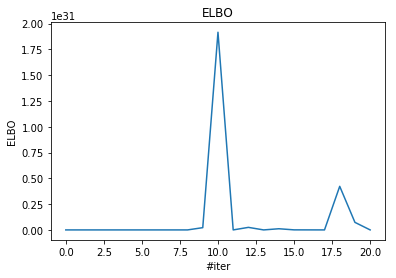

tensor(nan, grad_fn=<NegBackward>)
tensor(nan, grad_fn=<NegBackward>)


KeyboardInterrupt: 

In [643]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_network(model,train_loader,num_epoch = 10000):
    for epoch in range(num_epoch):
        i=0
        epoch_histiory = []
        
        for X_batch, y_batch in train_loader:
            model.train()
            # compute loss
            loss = -model(X_batch,train_size)
            print(loss)

            # train with backprop
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        
            epoch_histiory.append(float(loss))
        history.append(np.mean(epoch_histiory))
        i+=1
        if i%1==0:
            clear_output(True)
            plt.title("ELBO")
            plt.plot(np.array(history))
            plt.ylabel('ELBO')
            plt.xlabel('#iter')
            plt.show()
            i+=1
        torch.save(model,'model')

    history.append(float(loss))
    
    clear_output(True)
    plt.title("ELBO")
    plt.plot(np.array(history))
    plt.ylabel('ELBO')
    plt.xlabel('#epoch')
    plt.show()
    
train_network(model,train_loader)


In [638]:
# Classification performance

coors = []
colors = []
c = ['r','b','g','b']
for var in np.linspace(0.5,0.6,20):
    for mean in np.linspace(-0.1,0.1,20):
        for cls in range(4):
            S = create_samples(1000,mean,var,cls)
            coors += model.statistic(create_samples(1000,1,2,0).unsqueeze(-1))[0][0].data.numpy(),
            colors +=c[cls],

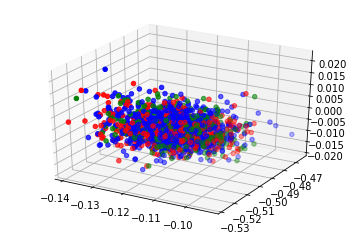

In [639]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*np.array(coors).T,c = colors)
plt.show()